<a id='top2'></a>
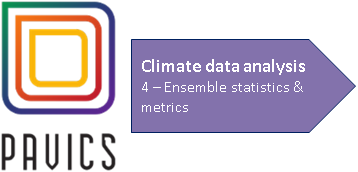

PAVICS ensemble functionalities rely on the <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html" target="_blank">xclim ensembles</a> module. Ensembles are an important aspect of climate change studies due to various sources of uncertainty in future climate projections and the associated need of their robust incorporation when attempting to produce actionable climate change information. This fourth tutorial will present PAVICS tools for ensemble dataset creation, statistics and metrics accessing output netcdf files created in the previous tutorial on climate indicators. 

This tutorial outlines steps for:

* [Ensemble dataset creation](#create_ens)
* [Ensemble statistics](#ens_stat)
* [Ensemble robustness](#ens_metric)

<div class="alert alert-info"> <strong>Info!</strong> This notebook accesses files created in tutorial 3. Be sure to run the <strong>advanced</strong> section of the <strong>climate indicator calculation</strong> tutorial before beginning.
</div>
<div class="alert alert-info">Advanced topics not covered by this tutorial : <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles-advanced.html#" target="_blank">Ensemble reduction</a>.

To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>

<a id='create_ens'></a>

## Ensemble dataset creation
The ensembles module allows us to easily concatenate multiple netcdf outputs into a single logical dataset via [`create_ensemble`](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#create_ensemble). We will re-use the output netcdf files from  the previous tutorial's advanced section, where we used a relatively simple workflow to calculate climate indicators using the **ESPO-G6-R2** ensemble.  Note the additional data dimension `realization` which is created.

*[return to top of page](#top2)*

<xarray.Dataset> Size: 30MB
Dimensions:           (realization: 15, time: 481, rlat: 22, rlon: 24)
Coordinates:
  * rlat              (rlat) float32 88B -7.29 -7.2 -7.11 ... -5.58 -5.49 -5.4
  * rlon              (rlon) float32 96B 376.4 376.4 376.5 ... 378.2 378.3 378.4
    rotated_pole      float32 4B 9.969e+36
    lat               (rlat, rlon) float32 2kB 47.94 47.91 47.88 ... 48.94 48.9
    lon               (rlat, rlon) float32 2kB -67.76 -67.64 ... -63.93 -63.81
  * time              (time) object 4kB 1980-12-01 00:00:00 ... 2100-12-01 00...
  * realization       (realization) int64 120B 0 1 2 3 4 5 ... 9 10 11 12 13 14
Data variables:
    tx_days_above_27  (realization, time, rlat, rlon) float64 30MB dask.array<chunksize=(1, 481, 22, 24), meta=np.ndarray>
Attributes: (12/80)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of RDRS v2.1, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    ...                              ...
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              MPI-M
    crs:                             EPSG:4326

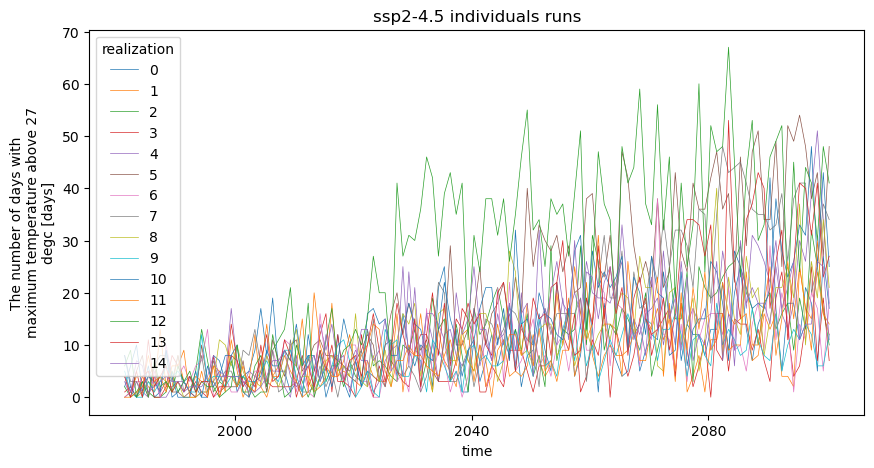

In [1]:
# NBVAL_IGNORE_OUTPUT

import logging
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
from clisops.core import subset
from xclim import ensembles as xens

logging.getLogger().disabled = True
warnings.simplefilter("ignore")
output = "/notebook_dir/writable-workspace/tmp/tutorial3/output"

infolder = Path(output)

# Create a list of ssp2-4.5 files  (n=11)
ncfiles = [d for d in infolder.glob("tx_days_above_27*seasonal*ssp245*.nc")]


# Create an ensemble dataset from the 11 simulations
ds_ens = xens.create_ensemble(ncfiles)
display(ds_ens)

# Plot time series of single grid point
lon = -66
lat = 48.5

ds1 = subset.subset_gridpoint(ds_ens, lon=lon, lat=lat)
#  plot summer season
ds1.tx_days_above_27.sel(time=ds1["time.season"] == "JJA").plot.line(
    figsize=(10, 5), x="time", linewidth=0.5
)
plt.title("ssp2-4.5 individuals runs")
display()

___
<a id='ens_stat'></a>
### Ensemble statistics
We can now employ functions for calculating statistics between realizations including calculating <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-percentiles" target="_blank">ensemble percentiles</a> as well as <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-statistics" target="_blank">ensemble mean, standard-deviation, maximum & minimum.</a>

<div class="alert alert-info">
<strong>Note : </strong> It is critical to retain all ensemble realizations throughout data treatment steps when creating a new type of summary output (for example annual spatial-means, or 30 year climate normals) such that the final step is the calculation of ensemble percentiles (or mean, min, max) between realizations.  In general one should try to remember that the mean of percentile (or min, max) values does not equal the percentile (or min, max) of the mean conditions.</div>

*[return to top of page](#top2)*

<xarray.Dataset> Size: 6MB
Dimensions:           (rlat: 22, rlon: 24, time: 481, percentiles: 3)
Coordinates:
  * rlat              (rlat) float32 88B -7.29 -7.2 -7.11 ... -5.58 -5.49 -5.4
  * rlon              (rlon) float32 96B 376.4 376.4 376.5 ... 378.2 378.3 378.4
    rotated_pole      float32 4B 9.969e+36
    lat               (rlat, rlon) float32 2kB dask.array<chunksize=(22, 24), meta=np.ndarray>
    lon               (rlat, rlon) float32 2kB dask.array<chunksize=(22, 24), meta=np.ndarray>
  * time              (time) object 4kB 1980-12-01 00:00:00 ... 2100-12-01 00...
  * percentiles       (percentiles) int64 24B 10 50 90
Data variables:
    tx_days_above_27  (time, rlat, rlon, percentiles) float64 6MB dask.array<chunksize=(481, 22, 24, 3), meta=np.ndarray>
Attributes: (12/85)
    long_name:                       The number of days with maximum temperat...
    standard_name:                   number_of_days_with_air_temperature_abov...
    cell_methods:                    time: maximum within days time: sum over...
    units:                           days
    history:                         [2023-03-28 12:26:23] regridded with arg...
    description:                     Seasonal number of days where daily maxi...
    ...                              ...
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              MPI-M
    crs:                             EPSG:4326

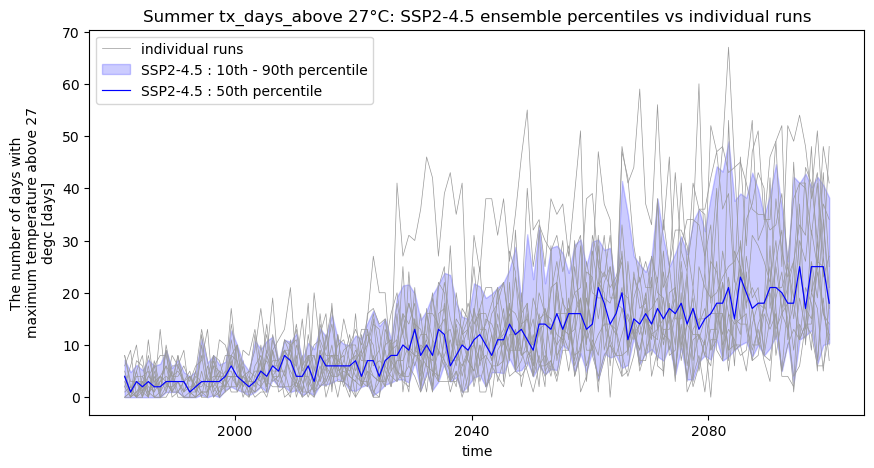

In [2]:
# NBVAL_IGNORE_OUTPUT

# Calculate percentiles
ds_perc = xens.ensemble_percentiles(ds_ens, values=[10, 50, 90], split=False)
display(ds_perc)

# compare with indiviudual runs
sel1 = ds1.tx_days_above_27.sel(time=ds1["time.season"] == "JJA")
sel1.plot.line(
    label="individual runs",
    color=[0.6, 0.6, 0.6],
    figsize=(10, 5),
    x="time",
    linewidth=0.5,
)

perc1 = subset.subset_gridpoint(ds_perc, lon=lon, lat=lat).tx_days_above_27.sel(
    time=ds_perc["time.season"] == "JJA"
)

# plot uncertainty bounds
plt.fill_between(
    color="b",
    label="SSP2-4.5 : 10th - 90th percentile",
    x=perc1.time.values,
    y1=perc1.sel(percentiles=10),
    y2=perc1.sel(percentiles=90),
    alpha=0.2,
)
# plot median
perc1.sel(percentiles=50).plot(
    label="SSP2-4.5 : 50th percentile",
    color="b",
    linewidth=0.85,
)

# combine legend entries for individual runs
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
l = plt.legend(by_label.values(), by_label.keys())
t = plt.title(
    "Summer tx_days_above 27°C: SSP2-4.5 ensemble percentiles vs individual runs"
)

___

<a id='ens_metric'></a>
### Ensemble robustness metrics
PAVICS <a href="https://xclim.readthedocs.io/en/stable/api.html#ensemble-robustness-metrics" target="_blank">robustness metrics</a> can be used to estimate the confidence of the climate change signal. Currently a small number of metrics are implemented based on the IPCC's fifth assessment report : <a href="https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter12_FINAL.pdf" target="_blank">IPCC AR5 WG1 - chapter 12</a> (see box 12.1) 

In the example below we use the `change_significance` method to examine the fraction of ensemble members that show a significant change between future and reference 30 year periods (left panel) and additionally the fraction of those members with significant future change that indicate an increase in future values (right panel)

*[return to top of page](#top2)*

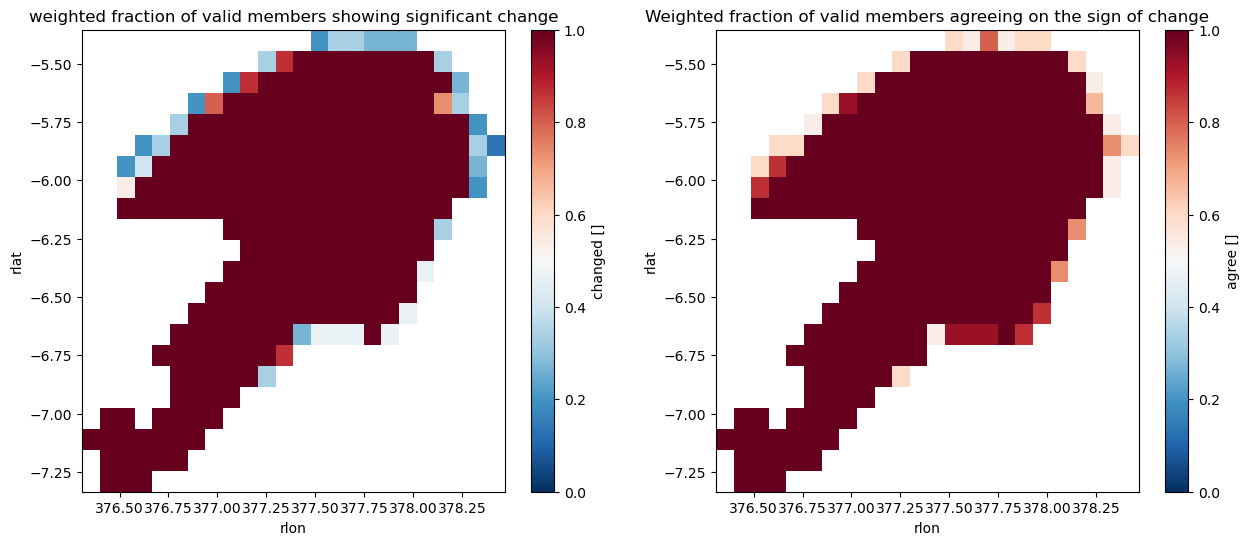

In [3]:
fut = ds_ens.sel(time=slice("2071", "2100")).chunk(dict(realization=-1))
ref = ds_ens.sel(time=slice("1981", "2010")).chunk(dict(realization=-1))

tx_days_above_27 = xens.robustness_fractions(
    fut.tx_days_above_27.sel(time=fut["time.season"] == "JJA"),
    ref.tx_days_above_27.sel(time=ref["time.season"] == "JJA"),
    test="ttest",
)
plt.figure(
    figsize=(15, 6),
)

plt.subplot(1, 2, 1)
tx_days_above_27.changed.plot(cmap="RdBu_r", vmin=0, vmax=1)
t1 = plt.title("weighted fraction of valid members showing significant change")

plt.subplot(1, 2, 2)
tx_days_above_27.agree.plot(cmap="RdBu_r", vmin=0, vmax=1)
t1 = plt.title("Weighted fraction of valid members agreeing on the sign of change")

___
### Notes
<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

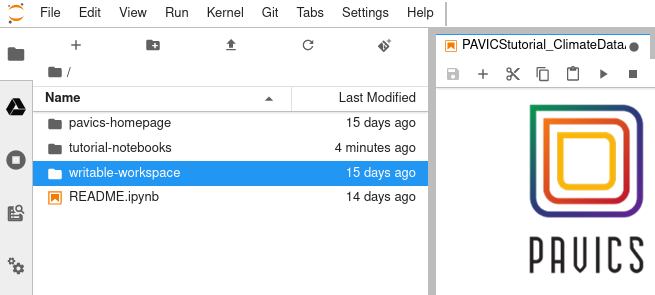

*[return to top of page](#top2)*